<center>

# Simpsons Classification




## Imports and working with data

We will use [this larger dataset](https://www.kaggle.com/jfgm2018/the-simpsons-dataset-compilation-49-characters) which fully includes given dataset.

In [1]:
import time
import os
import copy

import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
import PIL
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from mpl_toolkits.axes_grid1 import AxesGrid
import sklearn
from sklearn.metrics import confusion_matrix, f1_score

from matplotlib import colors, pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'
plt.ion()  # interactive mode

# !nvidia-smi
!C:\Windows\System32\DriverStore\FileRepository\nvamsi.inf_amd64_df86e36923fdc21b\nvidia-smi.exe
torch.cuda.is_available(), torch.cuda.get_device_name(0)

Sat Nov 21 15:03:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.30       Driver Version: 457.30       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    N/A /  N/A |    207MiB /  4096MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(True, 'GeForce GTX 1050')


|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      5204    C+G   ...llvad VPN\Mullvad VPN.exe    N/A      |
|    0   N/A  N/A      9520    C+G   ...4__8wekyb3d8bbwe\Time.exe    N/A      |
|    0   N/A  N/A     13320    C+G   ...cw5n1h2txyewy\LockApp.exe    N/A      |
|    0   N/A  N/A     14160    C+G   ...nputApp\TextInputHost.exe    N/A      |
|    0   N/A  N/A     15888    C+G   ...5n1h2txyewy\SearchApp.exe    N/A      |
|    0   N/A  N/A     16576    C+G   ...ekyb3d8bbwe\YourPhone.exe    N/A      |
|    0   N/A  N/A     16888    C+G   ...Roaming\Zoom\bin\Zoom.exe    N/A      |
+-----------------------------------------------------------------------------+


In [2]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def to_rgb(self, im):
        w, h = im.shape
        im_rgb = np.empty((w, h, 3), dtype='float32')
        im_rgb[:, :, :] = im[:, :, np.newaxis]
        return im_rgb

    def __getitem__(self, index):
        # some transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ]) 
        
        # rescale and convert to numpy
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        
        # if grayscale --> convert to RGB
        if len(x.shape) == 2:
            x = self.to_rgb(x)
        
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
TRAIN_DIR = Path('train_e/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [6]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [7]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

Давайте посмотрим на наших героев внутри датасета.

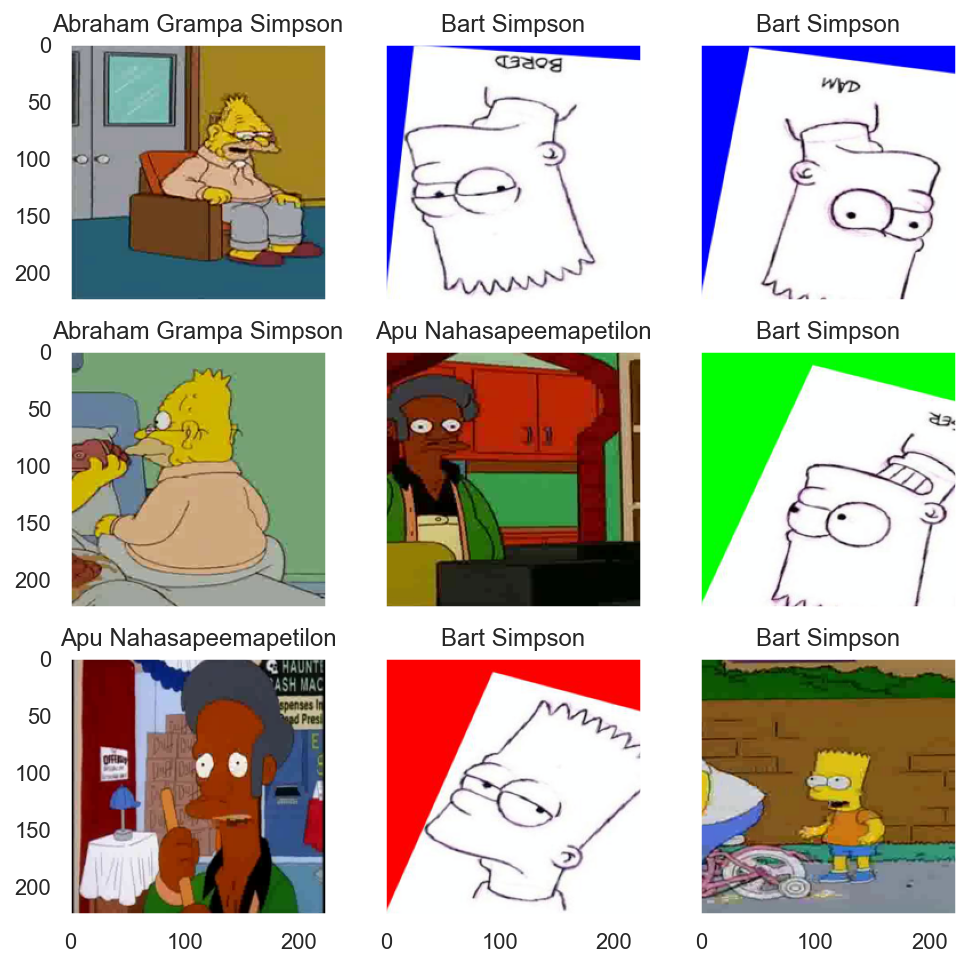

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Finetuning the convnet

Function to train the model based on [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html):

In [9]:
def train_model(model, train_dataset, val_dataset, criterion, optimizer, scheduler, num_epochs=2, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    history = []
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history.append((epoch_loss, epoch_acc))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

We will use resnet18 ([Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385))

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

n_classes = len(np.unique(train_val_labels))
model_ft.fc = nn.Linear(num_ftrs, n_classes)

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [12]:
model_tuned, history = train_model(model_ft,
                          train_dataset,
                          val_dataset,
                          criterion=criterion,
                          optimizer=optimizer_ft,
                          scheduler=exp_lr_scheduler,
                          num_epochs=8,
                          batch_size=64)

# or load the saved model
# model_ft.load_state_dict(torch.load('saved_model'))
# model_tuned = model_ft

Epoch 0/7
----------
train Loss: 1.5717 Acc: 0.6473
val Loss: 0.6529 Acc: 0.8653

Epoch 1/7
----------
train Loss: 0.4562 Acc: 0.9063
val Loss: 0.3455 Acc: 0.9250

Epoch 2/7
----------
train Loss: 0.2411 Acc: 0.9532
val Loss: 0.2370 Acc: 0.9458

Epoch 3/7
----------
train Loss: 0.1488 Acc: 0.9747
val Loss: 0.1890 Acc: 0.9574

Epoch 4/7
----------
train Loss: 0.0965 Acc: 0.9860
val Loss: 0.1621 Acc: 0.9627

Epoch 5/7
----------
train Loss: 0.0664 Acc: 0.9918
val Loss: 0.1486 Acc: 0.9673

Epoch 6/7
----------
train Loss: 0.0465 Acc: 0.9956
val Loss: 0.1377 Acc: 0.9681

Epoch 7/7
----------
train Loss: 0.0362 Acc: 0.9971
val Loss: 0.1361 Acc: 0.9684

Training complete in 63m 29s
Best val Acc: 0.968423


Save the model state:

In [34]:
torch.save(model_tuned.state_dict(), './saved_model')

Loss functions:

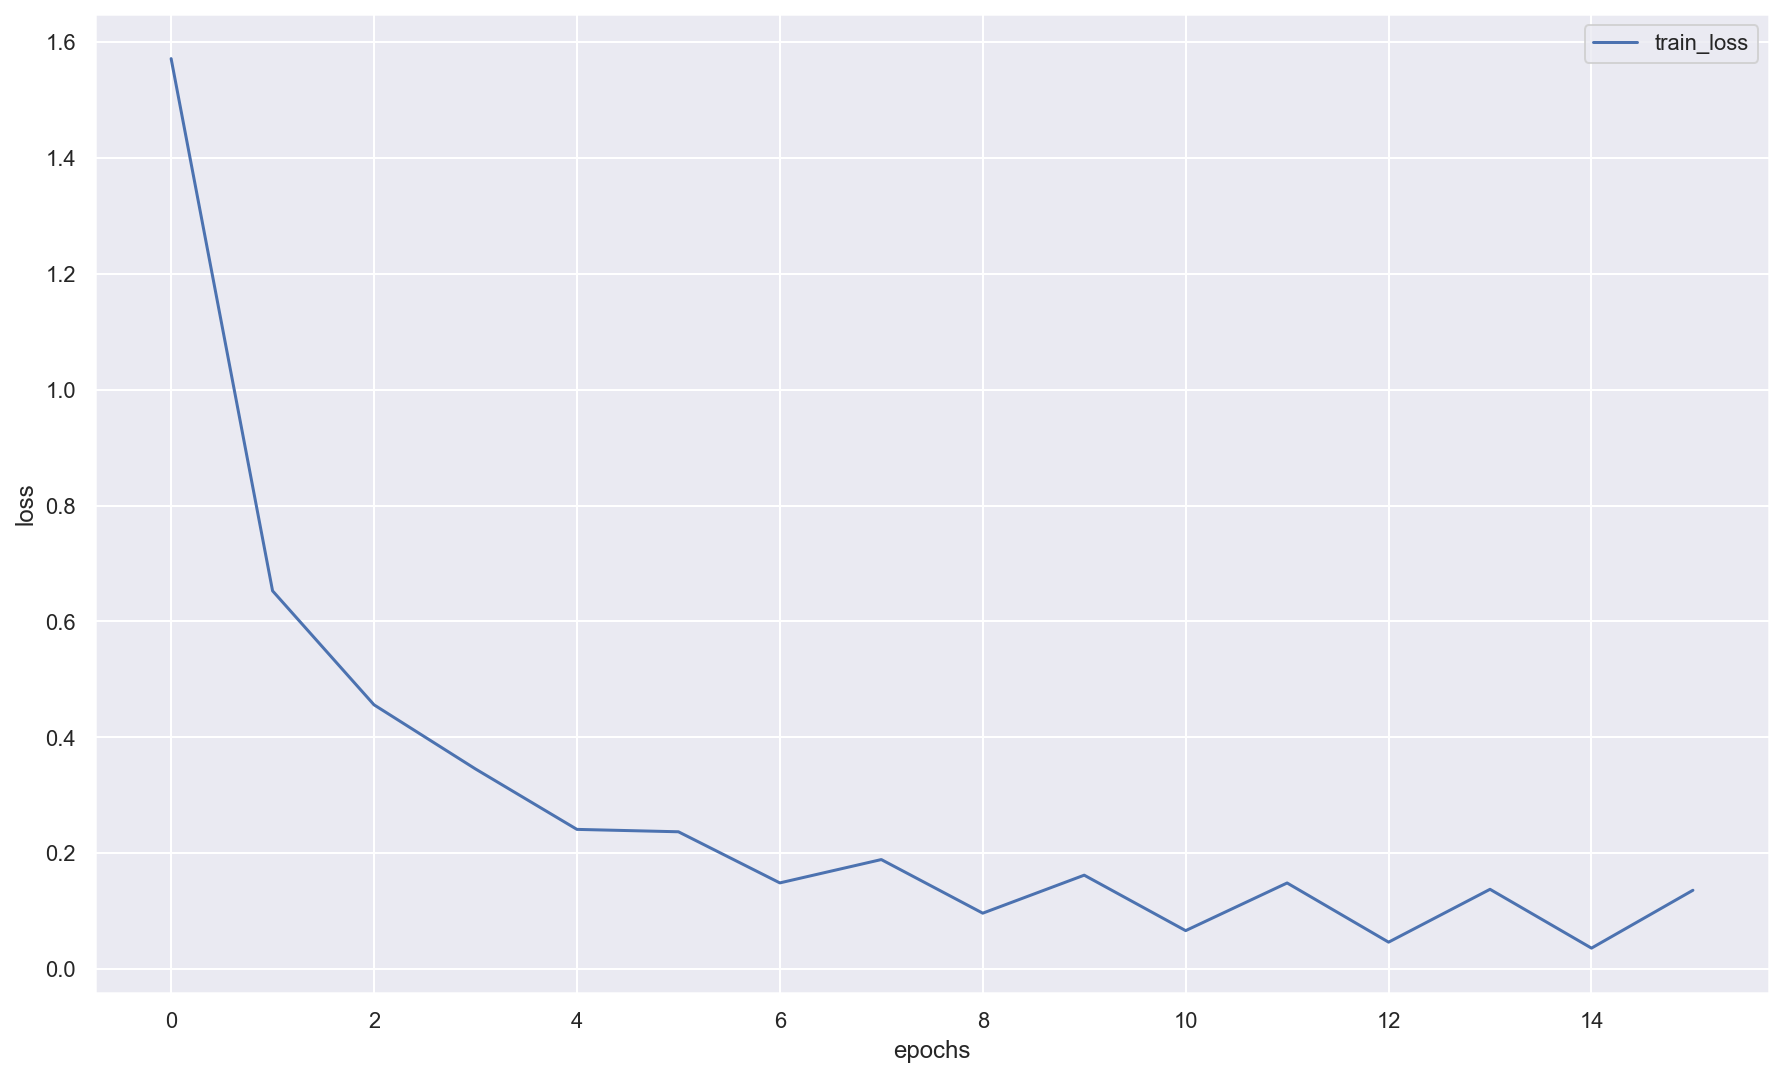

In [13]:
loss, acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [23]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_tuned, ex_img.unsqueeze(0))

In [24]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_tuned, imgs)

In [25]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [26]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

# preds_class = [label_encoder.classes_[i] for i in y_pred]

### f1-score

In [27]:
preds_class = list(y_pred)
f1_score(actual_labels, preds_class, average='micro')


1.0

### confidence

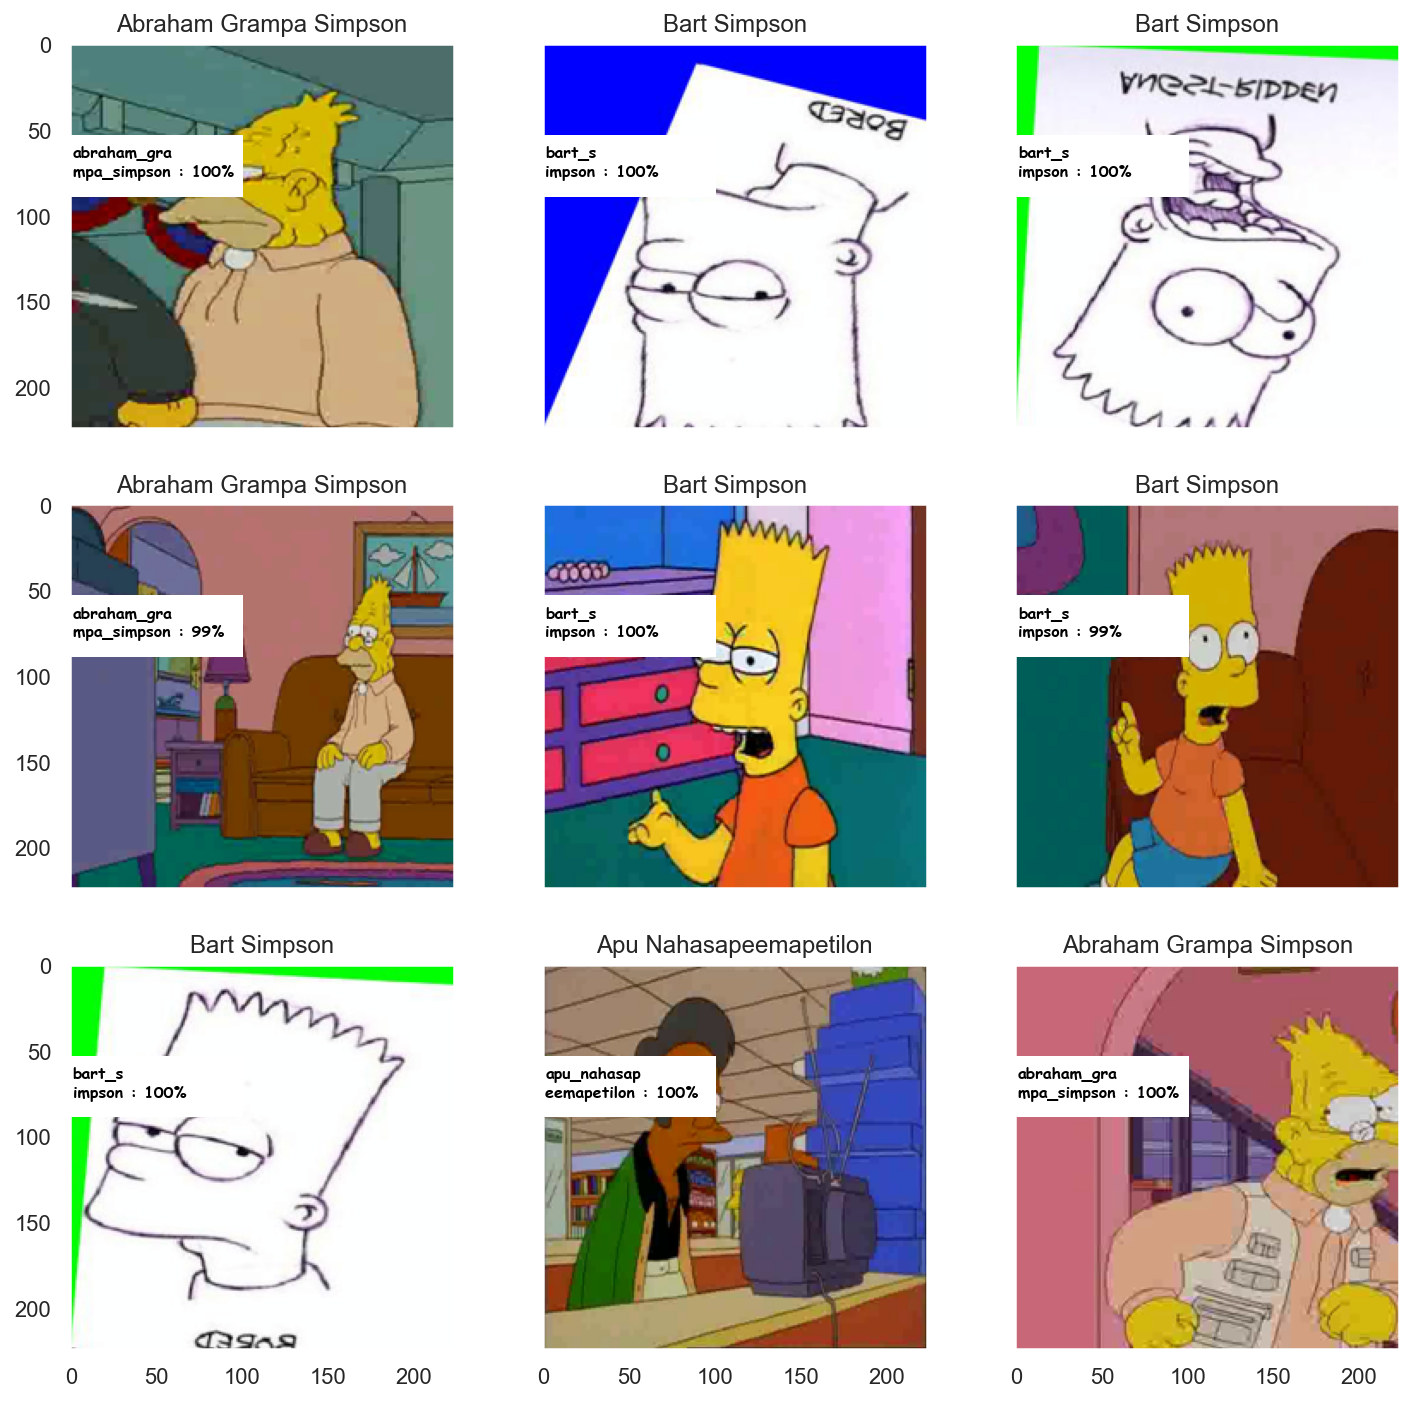

In [28]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_tuned, im_val.unsqueeze(0))
    prob_pred = predict_one_sample(model_tuned, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### confusion matrix

In [54]:
def confusion_matrix():
    # actual labels
#     actual = [image_datasets['val'][i][1] for i in range(len(image_datasets['val']))]
    actual = [val_dataset[i][1] for i in range(len(val_dataset))]

    # images corresponding
#     image = [image_datasets['val'][i][0] for i in range(len(image_datasets['val']))]
    image = [val_dataset[i][0] for i in range(len(val_dataset))]

    # dataloader
    img_conf_dataloader = DataLoader(image,
                                     batch_size=64,
                                     shuffle=False)

    # predict labels
    probs = predict(model_tuned, img_conf_dataloader)
    preds = np.argmax(probs, axis=1)

    # dataframe
    df = pd.DataFrame({'actual': actual, 'preds': preds})

    # confusion_matrix
    confusion_matrix = pd.crosstab(df['actual'],
                                   df['preds'],
                                   rownames=['Actual'],
                                   colnames=['Predicted'],
                                   margins=False)

    # load label_encoder
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    # get classes names
    yticklabels = label_encoder.classes_

    plt.subplots(figsize=(14, 14))

    sns.heatmap(confusion_matrix,
               annot=True,
               fmt="d",
               linewidths=0.5,
               cmap="YlGnBu",
               cbar=False,
               vmax=30,
               yticklabels=yticklabels,
               xticklabels=yticklabels)

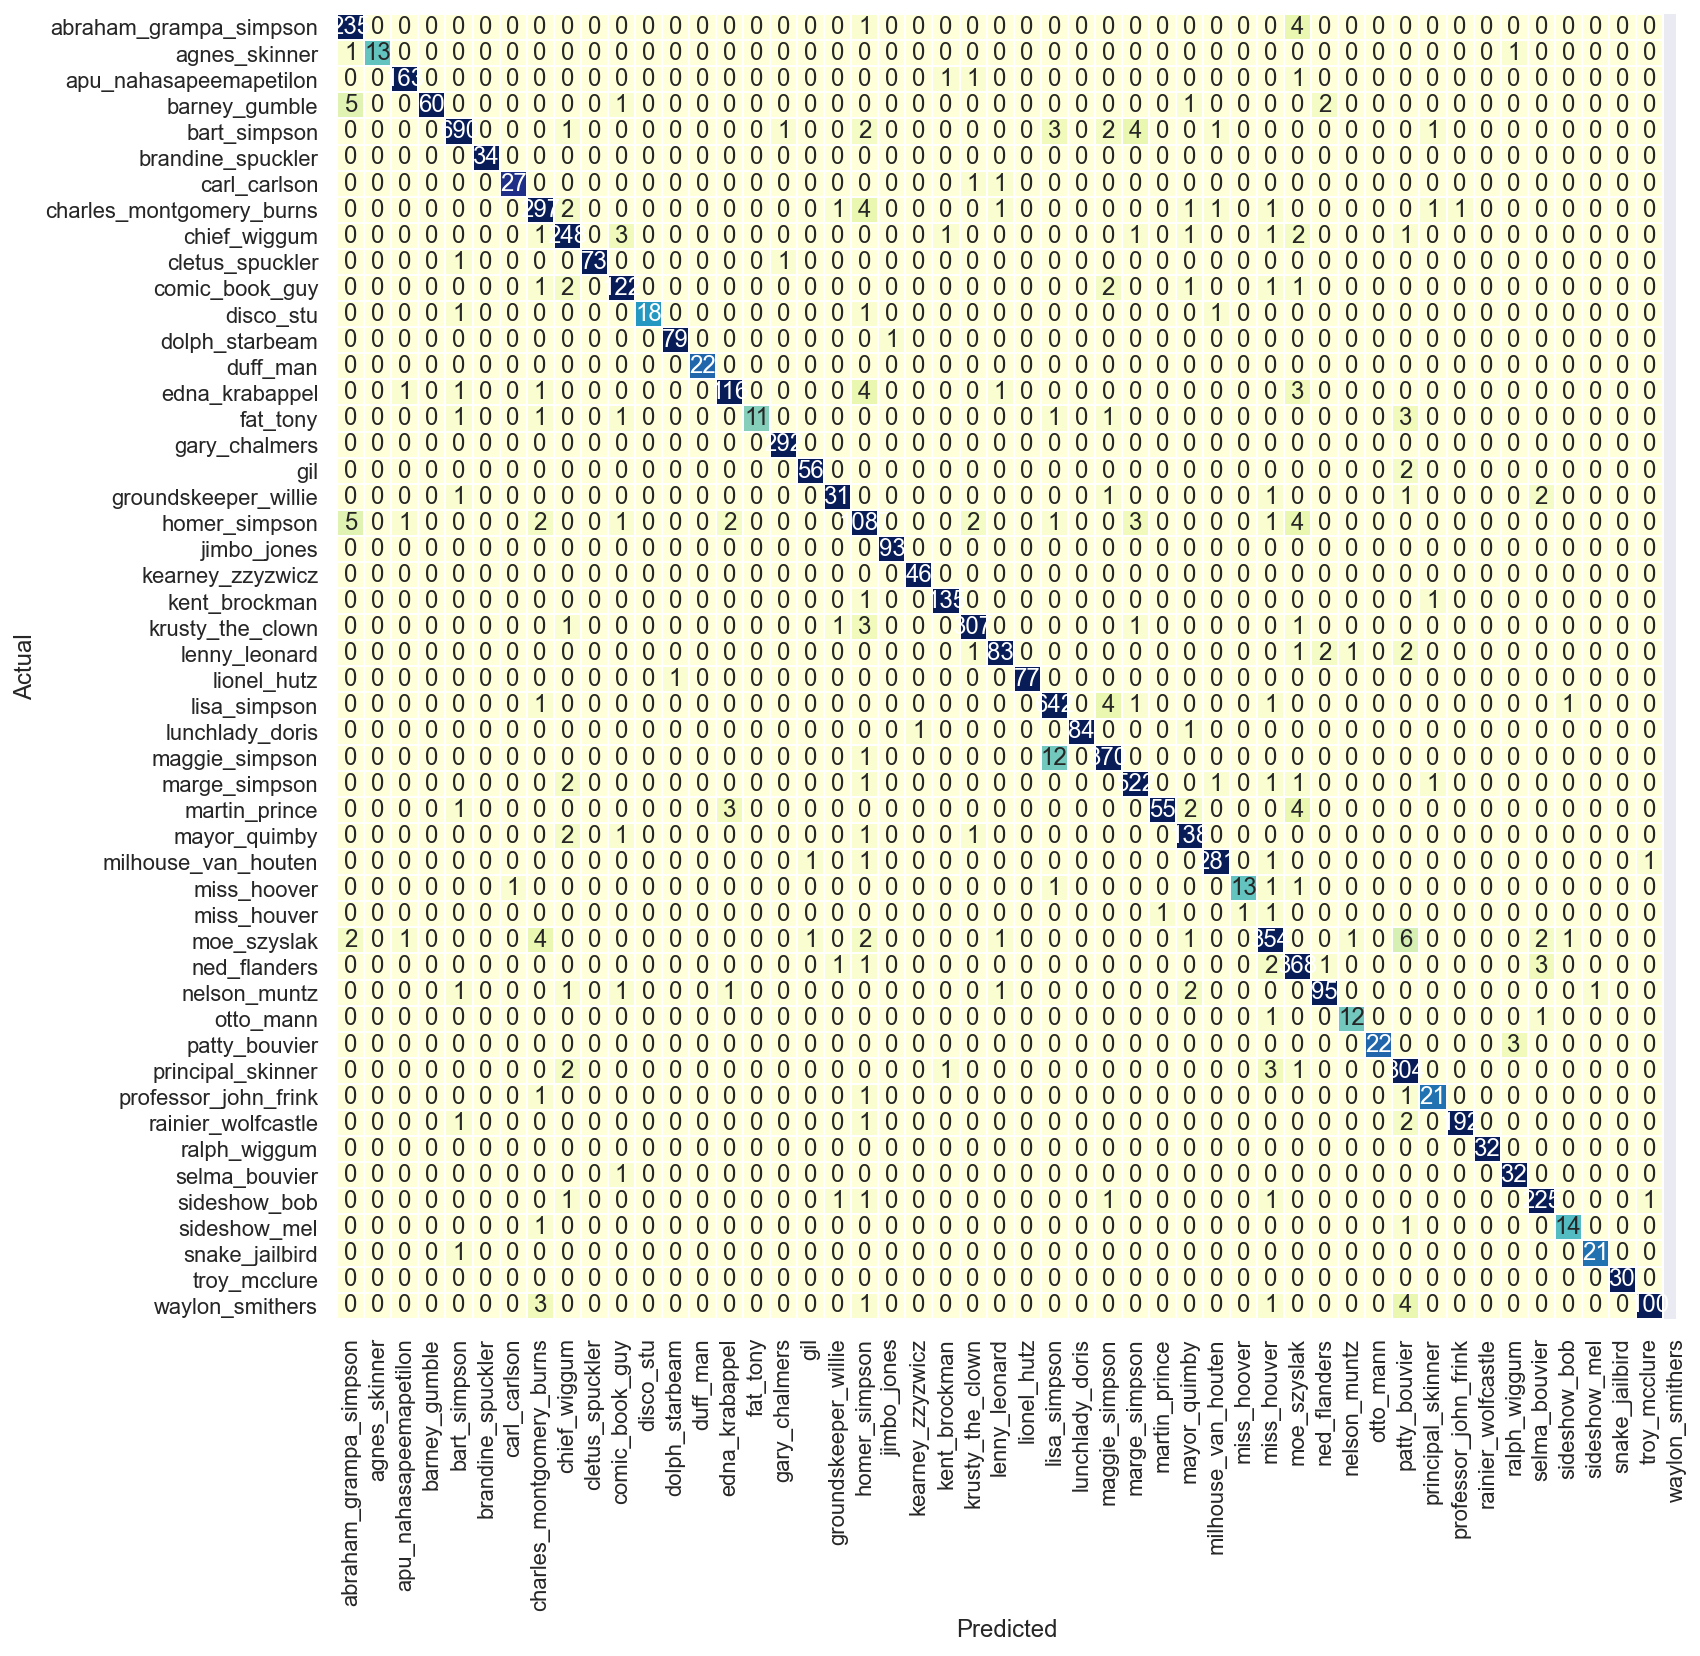

In [53]:
confusion_matrix()

## Submission

In [29]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
# probs = predict(simple_cnn, test_loader)
probs = predict(model_tuned, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [31]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [33]:
my_submit.to_csv('simpsons.csv', index=False)

_Глеб_Бузин на kaggle_

```










```
## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
